In [2]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

# Step 1: Tokenize the SMILES Strings

In [3]:
# Example dataset
smiles_data = [
    "CC(C)CC1=CC=C(C=C1)C(C)C(=O)O",  # Example SMILES strings
    "C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl",
    "CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(C=C3)Cl"
]
labels = [1, 0, 1]  # Binary labels for classification

# Tokenize SMILES
unique_chars = set("".join(smiles_data))
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

def tokenize_smiles(smiles):
    return [char_to_idx[char] for char in smiles]

tokenized_smiles = [tokenize_smiles(s) for s in smiles_data]
print("Tokenized SMILES:", tokenized_smiles)


Tokenized SMILES: [[4, 4, 9, 4, 5, 4, 4, 6, 0, 4, 4, 0, 4, 9, 4, 0, 4, 6, 5, 4, 9, 4, 5, 4, 9, 0, 7, 5, 7], [4, 0, 4, 4, 7, 4, 6, 0, 4, 9, 4, 0, 4, 9, 4, 0, 4, 6, 5, 4, 4, 9, 0, 7, 5, 7, 5, 4, 8], [4, 4, 4, 1, 9, 4, 4, 4, 5, 4, 9, 0, 7, 5, 4, 4, 6, 0, 4, 9, 1, 0, 4, 3, 1, 6, 4, 0, 4, 9, 4, 0, 4, 3, 5, 4, 8, 5, 4, 2, 0, 4, 4, 0, 4, 9, 4, 0, 4, 2, 5, 4, 8]]


In [26]:
# Load pd_train
pd_train = pd.read_csv("data_smiles/Training_Group.csv")
pd_train["label"] = pd_train["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_train.shape)
print(pd_train["label"].value_counts())
pd_train.head()

(1241, 3)
label
1    683
0    558
Name: count, dtype: int64


,Smiles,Liver,label
0,S=C=Nc1c2c(ccc1)cccc2,Hepatotoxicity,1
1,c1(c(cc(cc1[N+](=O)[O-])[N+](=O)[O-])[N+](=O)[...,Hepatotoxicity,1
2,c1(c(cc(cc1)[N+](=O)[O-])[N+](=O)[O-])O,Hepatotoxicity,1
3,O(CCO)CC,Hepatotoxicity,1
4,Oc1cc2c(cc1)cccc2,Hepatotoxicity,1


In [27]:
# Load pd_test
pd_test = pd.read_csv("data_smiles/Testing_Group.csv")
pd_test["label"] = pd_test["Liver"].apply(lambda x: 1 if x == "Hepatotoxicity" else 0)
print(pd_test.shape)
print(pd_test["label"].value_counts())
pd_test.head()

(286, 3)
label
1    221
0     65
Name: count, dtype: int64


,Smiles,Liver,label
0,C[C@@H](C(=O)N[C@@H](C)C(=O)NC1[C@H]2[C@@H]1CN...,Hepatotoxicity,1
1,C=CCOC1=C(C=C(C=C1)CC(=O)O)Cl,Hepatotoxicity,1
2,CCCN(CCC)C(=O)CC1=C(N=C2N1C=C(C=C2)Cl)C3=CC=C(...,Hepatotoxicity,1
3,C1CC2=CC=CC=C2C(C3=CC=CC=C31)NCCCCCCC(=O)O,Hepatotoxicity,1
4,C1=CC=C(C=C1)CN2C3=CC=CC=C3C(=N2)OCC(=O)O,Hepatotoxicity,1


In [28]:
pd_train["dataset"] = "train"
pd_test["dataset"] = "test"
df = pd.concat([pd_train, pd_test])
print(df.shape)
df["dataset"].value_counts()

(1527, 4)


dataset
train    1241
test      286
Name: count, dtype: int64

In [29]:
# calculate the length of the Smiles strings
df["smiles_len"] = df["Smiles"].apply(lambda x: len(x))

# smiels length distribution of train and test
df.groupby("dataset")["smiles_len"].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
test,286.0,54.370629,39.480251,10.0,32.0,44.0,60.0,284.0
train,1241.0,63.667204,61.782302,8.0,36.0,48.0,68.0,748.0


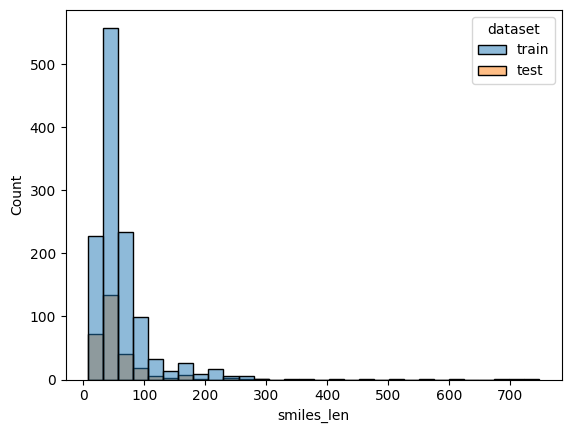

In [30]:
# plot train, test smiles length
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df, x="smiles_len", hue="dataset", bins=30)
plt.show()

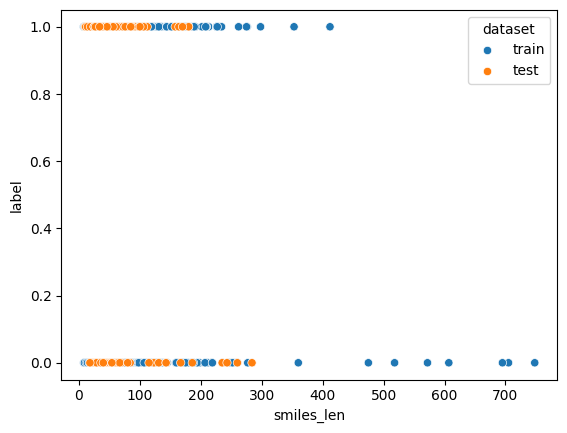

In [31]:
# scatter plot train, test smiles length vs label
sns.scatterplot(data=df, x="smiles_len", y="label", hue="dataset")
plt.show()

In [32]:
# filter out the Smiles strings that are too long using the 95% quantile
df = df[df["smiles_len"] <= df["smiles_len"].quantile(0.95)]
df.groupby("dataset")["smiles_len"].describe()

,count,mean,std,min,25%,50%,75%,max
dataset,,,,,,,,
test,277.0,49.259928,26.839788,10.0,32.0,43.0,58.0,165.0
train,1175.0,52.665532,26.927905,8.0,35.0,46.0,65.0,165.0


In [33]:
# check data size after filtering for each dataset with label
df.groupby(["dataset", "label"]).size()

dataset  label
test     0         59
         1        218
train    0        527
         1        648
dtype: int64

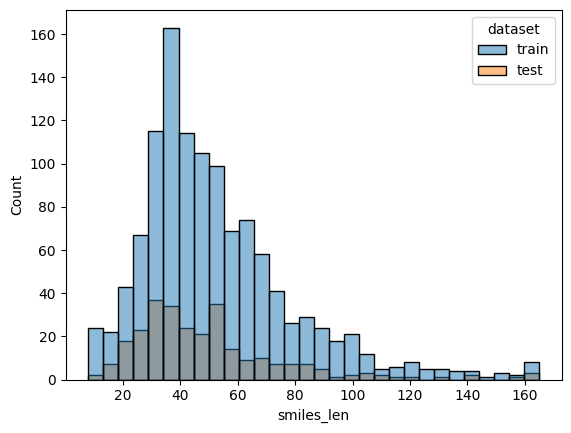

In [34]:
# plot train, test smiles length
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(df, x="smiles_len", hue="dataset", bins=30)
plt.show()

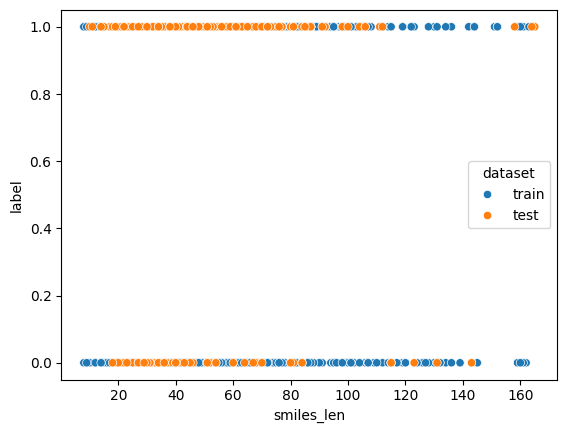

In [35]:
# scatter plot train, test smiles length vs label
sns.scatterplot(data=df, x="smiles_len", y="label", hue="dataset")
plt.show()

In [36]:
# Tokenize SMILES
unique_chars = set("".join(df["Smiles"]))
char_to_idx = {char: idx for idx, char in enumerate(unique_chars)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

def tokenize_smiles(smiles):
    return [char_to_idx[char] for char in smiles]

# tokenize for X_train, y_train, X_test, y_test
X_train = [tokenize_smiles(s) for s in df[df["dataset"] == "train"]["Smiles"]]
y_train = df[df["dataset"] == "train"]["label"].values
X_test = [tokenize_smiles(s) for s in df[df["dataset"] == "test"]["Smiles"]]
y_test = df[df["dataset"] == "test"]["label"].values

# Step 2: Create a Dataset and DataLoader

In [37]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, labels, max_len=200):
        self.smiles = [s[:max_len] for s in smiles]
        self.labels = labels
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        x = np.zeros(self.max_len, dtype=int)
        x[:len(self.smiles[idx])] = self.smiles[idx]
        y = self.labels[idx]
        return torch.tensor(x, dtype=torch.long), torch.tensor(y, dtype=torch.float)

# Create train and test sets
train_dataset = SmilesDataset(X_train, y_train)
test_dataset = SmilesDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Step 3: Define Models

In [38]:
import torch.nn as nn
import torch.optim as optim

class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        out = self.fc(hidden[-1])
        return out

# Model instantiation and hyperparameters
vocab_size = len(char_to_idx)
embedding_dim = 16
hidden_dim = 32
output_dim = 1

rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)


In [39]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, (hidden, cell) = self.lstm(embedded)
        out = self.fc(hidden[-1])
        return out

lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)


In [44]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_heads, hidden_dim, output_dim, num_layers):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.position_embedding = nn.Parameter(torch.zeros(1, 200, embedding_dim))  # Sequence length = 200
        encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x) + self.position_embedding[:, :x.size(1), :]
        output = self.transformer(embedded)
        out = self.fc(output[:, 0, :])  # Use the first token's output for classification
        return out

transformer_model = TransformerModel(vocab_size, embedding_dim, num_heads=4, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=2)


# Step 4: Train and Evaluate

In [46]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix


In [48]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    for x_batch, y_batch in dataloader:
        optimizer.zero_grad()
        predictions = model(x_batch).squeeze(1)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()

# def evaluate(model, dataloader):
#     model.eval()
#     correct, total = 0, 0
#     with torch.no_grad():
#         for x_batch, y_batch in dataloader:
#             predictions = torch.sigmoid(model(x_batch).squeeze(1))
#             predicted_labels = (predictions > 0.5).float()
#             correct += (predicted_labels == y_batch).sum().item()
#             total += y_batch.size(0)
#     return correct / total

def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_predictions = []

    # Collect predictions and true labels
    with torch.no_grad():
        for x_batch, y_batch in dataloader:
            predictions = torch.sigmoid(model(x_batch).squeeze(1))
            predicted_labels = (predictions > 0.5).float()
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Convert lists to numpy arrays
    all_labels = np.array(all_labels)
    all_predictions = np.array(all_predictions)
    predicted_labels = (all_predictions > 0.5).astype(int)

    # Calculate metrics
    auc = roc_auc_score(all_labels, all_predictions)
    precision = precision_score(all_labels, predicted_labels)
    recall = recall_score(all_labels, predicted_labels)  # Recall = Sensitivity
    tn, fp, fn, tp = confusion_matrix(all_labels, predicted_labels).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

    # Print or return results
    results = {
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "Sensitivity": sensitivity,
        "Specificity": specificity
    }
    return results

# Train and evaluate RNN model
for epoch in range(5):
    train(rnn_model, train_loader, criterion, optimizer)
    results = evaluate(rnn_model, test_loader)
    print(f"Epoch {epoch + 1}, RNN Model results: {results}")

Epoch 1, RNN Model results: {'AUC': 0.4833618410822578, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
Epoch 2, RNN Model results: {'AUC': 0.4625252682320012, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
Epoch 3, RNN Model results: {'AUC': 0.5, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
Epoch 4, RNN Model results: {'AUC': 0.5, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
Epoch 5, RNN Model results: {'AUC': 0.49770642201834864, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}


In [50]:
# Similarly, train and evaluate LSTM model
for epoch in range(5):
    train(lstm_model, train_loader, criterion, optimizer)
    results = evaluate(lstm_model, test_loader)
    print(f"Epoch {epoch + 1}, LSTM Model results: {results}")

/opt/homebrew/anaconda3/envs/dili/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1, LSTM Model results: {'AUC': 0.5022935779816514, 'Precision': 0.0, 'Recall': 0.0, 'Sensitivity': 0.0, 'Specificity': 1.0}


/opt/homebrew/anaconda3/envs/dili/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2, LSTM Model results: {'AUC': 0.5022935779816514, 'Precision': 0.0, 'Recall': 0.0, 'Sensitivity': 0.0, 'Specificity': 1.0}


/opt/homebrew/anaconda3/envs/dili/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 3, LSTM Model results: {'AUC': 0.5022935779816514, 'Precision': 0.0, 'Recall': 0.0, 'Sensitivity': 0.0, 'Specificity': 1.0}


/opt/homebrew/anaconda3/envs/dili/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4, LSTM Model results: {'AUC': 0.5022935779816514, 'Precision': 0.0, 'Recall': 0.0, 'Sensitivity': 0.0, 'Specificity': 1.0}
Epoch 5, LSTM Model results: {'AUC': 0.5022935779816514, 'Precision': 0.0, 'Recall': 0.0, 'Sensitivity': 0.0, 'Specificity': 1.0}


/opt/homebrew/anaconda3/envs/dili/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# Similarly, train and evaluate Transformer model
for epoch in range(5):
    train(transformer_model, train_loader, criterion, optimizer)
    results = evaluate(transformer_model, test_loader)
    print(f"Epoch {epoch + 1}, Transformer Model results: {results}")

Epoch 1, Transformer Model results: {'AUC': 0.5, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
Epoch 2, Transformer Model results: {'AUC': 0.5, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
Epoch 3, Transformer Model results: {'AUC': 0.5, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
Epoch 4, Transformer Model results: {'AUC': 0.5, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
Epoch 5, Transformer Model results: {'AUC': 0.5, 'Precision': 0.7870036101083032, 'Recall': 1.0, 'Sensitivity': 1.0, 'Specificity': 0.0}
